# Requirements

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, precision_recall_fscore_support
import seaborn as sns
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import random

# Dataset loader

In [2]:
train_dir = './hmt_dataset/HMT_train' #you should change to your directory
test_dir = './hmt_dataset/HMT_test' #you should change to your directory

train_datagen = ImageDataGenerator(rescale=1/255.,
shear_range=0.1,
rotation_range=15,
horizontal_flip=True,
vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=True)

test_generator = test_datagen.flow_from_directory(test_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=False)

Found 4504 images belonging to 8 classes.
Found 496 images belonging to 8 classes.


Overrided

# Create Model

In [3]:
weight_decay = 5e-4
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten?

#model.add(Flatten())
model.add(GlobalAveragePooling2D())
#model.add(Dense(1024, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
#                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(8, activation='softmax', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                    

# Training

In [5]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=['accuracy'])

In [6]:
def lr_scheduler(epoch):
    base_ep = 15
    return 1e-3 * (.5 ** (epoch // base_ep))
lr_reduce_cb = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir='log2', write_graph=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=8, min_delta=0.)

In [64]:
model.fit(train_generator,
                    steps_per_epoch=train_generator.n // 32,
                    epochs=2,
                    callbacks=[tensorboard_cb],                  
                    shuffle = True,
                    verbose=1)

Epoch 1/2
140/140 [==============================] - 34s 245ms/step - loss: 0.6136 - accuracy: 0.8171
Epoch 2/2
140/140 [==============================] - 34s 244ms/step - loss: 0.5851 - accuracy: 0.8354


In [11]:
model.save('HMT.h5')

# Load Model

In [3]:
model=load_model('./models/HMT.h5')

In [852]:
def my_summary_iterator(path):
    for r in tf_record.tf_record_iterator(path):
        yield event_pb2.Event.FromString(r)
train_acc = []
train_loss = []
train_lr = []
print('log2/train/' + os.listdir('log2/train')[-1])
for e in my_summary_iterator('./log2/train/' + os.listdir('./log2/train')[0]):
    for v in e.summary.value:
        t = tf.make_ndarray(v.tensor)
        if v.tag == 'epoch_accuracy':
          train_acc.append(t)
        elif v.tag == 'epoch_loss':
          train_loss.append(t)

log2/train/events.out.tfevents.1645777871.DESKTOP-DCHIVG9.48664.4.v2


Text(0.5, 1.0, 'Training progress: Accuracy')

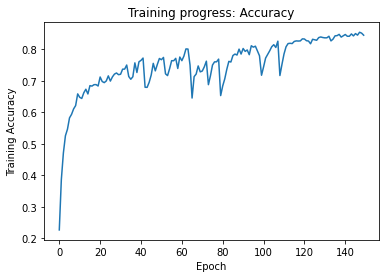

In [853]:
plt.plot(np.arange(len(train_acc)), train_acc)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training progress: Accuracy')

Text(0.5, 1.0, 'Training progress: Loss')

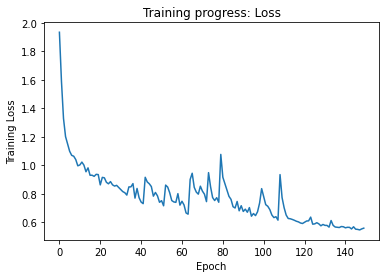

In [854]:
plt.plot(np.arange(len(train_loss)), train_loss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training progress: Loss')

# Plotting the training progress

In [4]:
##Task3-Question1
##b. Overall classification accuracy on the test set.

loss, acc = model.evaluate(test_generator, verbose=1)

16/16 [==============================] - 5s 173ms/step - loss: 0.5554 - accuracy: 0.8347


In [5]:
print('Overall classfication accuracy on the test set:',acc)

Overall classfication accuracy on the test set: 0.8346773982048035


In [6]:
##c. Class-wise classification accuracy for all classes.

In [7]:
onehot_predictions = model.predict(test_generator, verbose=1)

16/16 [==============================] - 1s 48ms/step


In [8]:
onehot_labels = np.concatenate([test_generator[i][1] for i in range(16)], axis=0)

In [9]:
labels = np.argmax(onehot_labels, axis=1)
predictions = np.argmax(onehot_predictions, axis=1)

In [10]:
class_matrix = confusion_matrix(labels,predictions)
class_acc = class_matrix.diagonal()/class_matrix.sum(axis = 1)

In [11]:
classes=['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty']
for i,j in enumerate(classes):
    print(j,'class accuracy:',round(class_acc[i],2))

Tumor class accuracy: 0.85
Stroma class accuracy: 0.76
Complex class accuracy: 0.77
Lympho class accuracy: 0.85
Debris class accuracy: 0.66
Mucosa class accuracy: 0.82
Adiopse class accuracy: 0.95
Empty class accuracy: 1.0


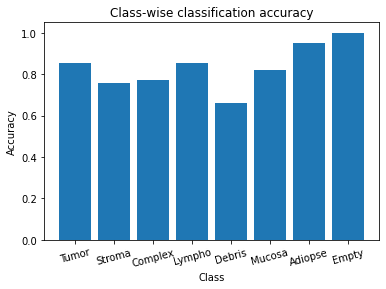

In [12]:
plt.bar(classes,class_acc)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Class-wise classification accuracy')
plt.xticks(rotation=15)
plt.show()

In [863]:
##d. Plot the classification ROC and AUC curves for each class

<Figure size 432x288 with 0 Axes>

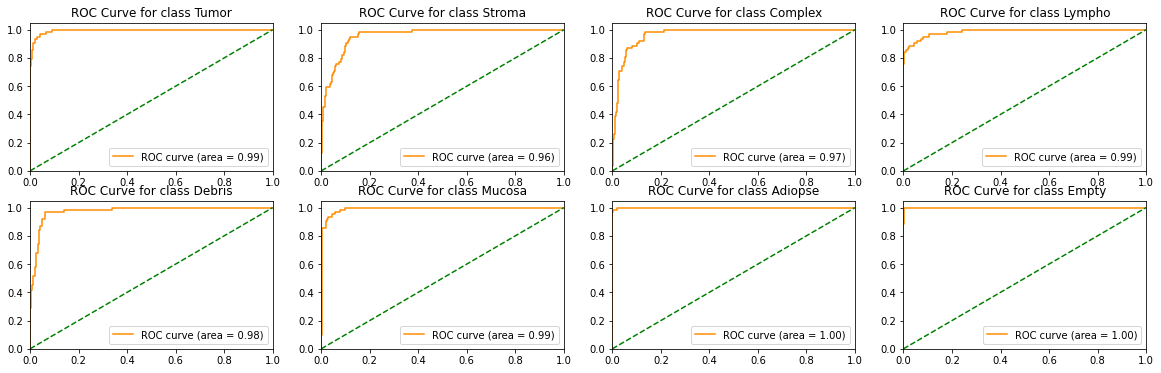

In [864]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range (8) :
    fpr[i], tpr[i], _= roc_curve(onehot_labels[:, i], onehot_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
fig, axs = plt.subplots(2, 4, figsize=(20, 6))
for i, ax in zip(range(8), axs.ravel()):
    ax.plot(fpr[i],tpr[i],color='darkorange',label= 'ROC curve (area = %0.2f)' % roc_auc[i])
    ax.plot([0, 1], [0, 1], 'g--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_title('ROC Curve for class {}'. format(classes[i]))
    ax.legend(loc= "lower right")

In [865]:
##e. Plot the normalized confusion matrix.

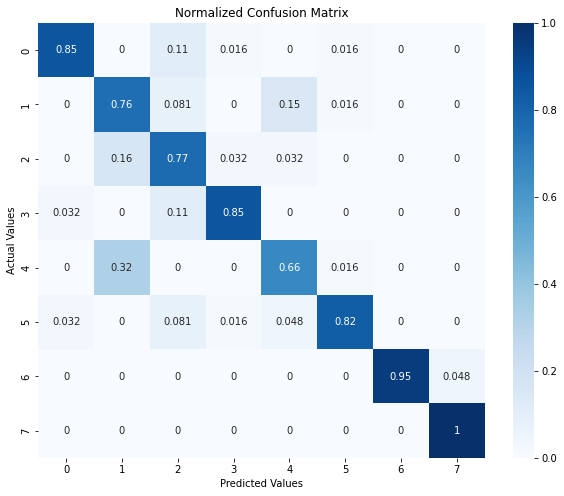

In [866]:
#e. Plot the normalized confusion matrix.
conf_matrix= confusion_matrix(labels, predictions, normalize= 'true')
plt.figure(figsize = (10,8))
ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues')
ax.set_title('Normalized Confusion Matrix')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')
plt.show()

In [867]:
##f. Precision, Recall, and F-1 score on the test set.

In [868]:
precision, recall, f1,support= precision_recall_fscore_support(labels, predictions, average='weighted')
print('Test set precision score is', round(precision,2), 'recall score is', round(recall,2), 'f1 score is', round(f1,2))

Test set precision score is 0.85 recall score is 0.83 f1 score is 0.84


# Explanation

Load the explainer library

In [869]:
from xai_utils import *

Load a batch of images

In [1081]:
test_generator.reset()

In [1082]:
image_batch,label_batch=test_generator.next()

Classes:

In [1083]:
classes=['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty']

Predict a single image

In [1084]:
index=8

In [1085]:
prediction=model(image_batch)
print('True label: '+classes[np.argmax(label_batch[index])])
print('Predicted_label: '+classes[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))

True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.96617067


Generate explanation map

## Integrated Gradients

In [1147]:
def get_unique_class_image(dataloader, explainer,model=model):
    plt.figure(figsize=(20,20))
    dataloader.reset()
    classes=['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty']
    unique = []
    c = 0
    while len(unique) < 8:
        image_batch,label_batch=dataloader.next()
        for i,j in enumerate(label_batch.argmax(axis=1)):
            if j not in unique:
                c += 1
                unique.append(j)
                if explainer == 'LIME':
                    result = LIME(image_batch[i],label=j)
                elif explainer == 'grad_cam':
                    result = grad_cam(model, np.expand_dims(image_batch[i], axis=0), 'max_pooling2d_1')
                else:
                    integrated_gradients, result = explainer(image_batch[i],label=j)
                plt.subplot(4,4,c)
                plt.imshow(image_batch[i])
                plt.axis('off')
                plt.title('Original Image '+ classes[j])
                c += 1
                plt.subplot(4,4,c)
                plt.imshow(result)
                plt.axis('off')
                if explainer==IG:
                    plt.title('Explanation map (IG) class ('+classes[j]+')')
                else:
                    plt.title('Explanation map ('+explainer+') class ('+classes[j]+')')

In [1148]:
def IG(inp, step = range(50), label = None, model = model):
    t_input = tf.convert_to_tensor(inp)
    baseline = np.zeros(inp.shape)
    path_inputs = np.asarray([baseline + (i/(step[-1]+1))*(inp-baseline) for i in step])
    with tf.GradientTape() as tape:
        inputs = tf.cast(path_inputs, tf.float32)
        tape.watch(inputs)
        predictions = model(inputs)
        loss = predictions[:, label]

    grads = tape.gradient(loss, inputs)
    grads = (grads[:-1] + grads[1:]) / 2.0
    integrated_gradients = (inp-baseline)*np.average(grads, axis=0)
    result = np.average(integrated_gradients, axis=2)
    result = np.expand_dims(result, 2) * [0, 255, 0]
    result /= result.max()
    #result = np.clip(0.7 * inp + 0.6 * result, 0, 255)
    return integrated_gradients, result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


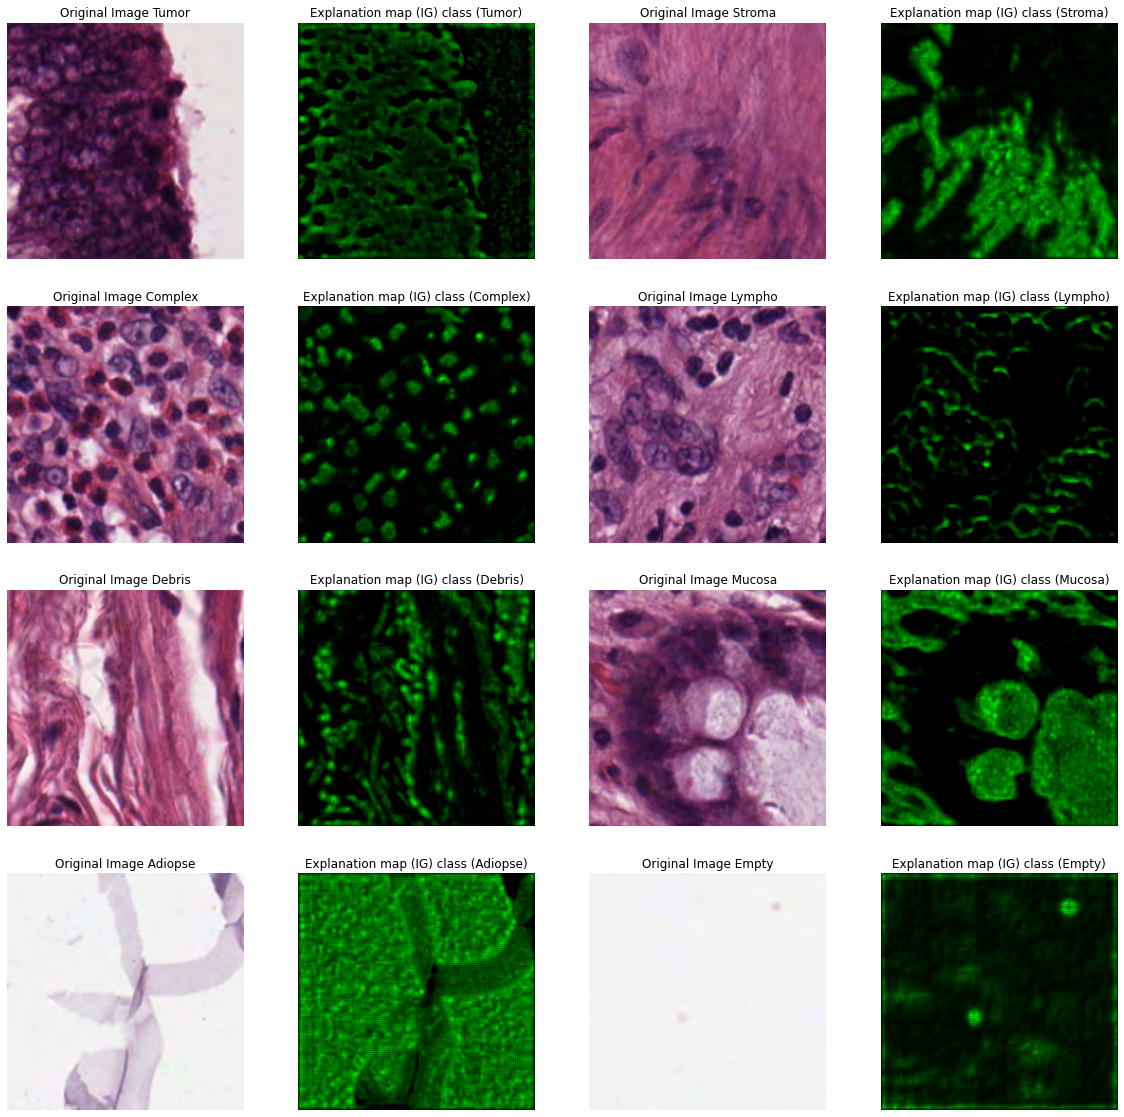

In [1149]:
get_unique_class_image(test_generator,IG)

## Grad-CAM (Gradient-based Class Activation Mapping)

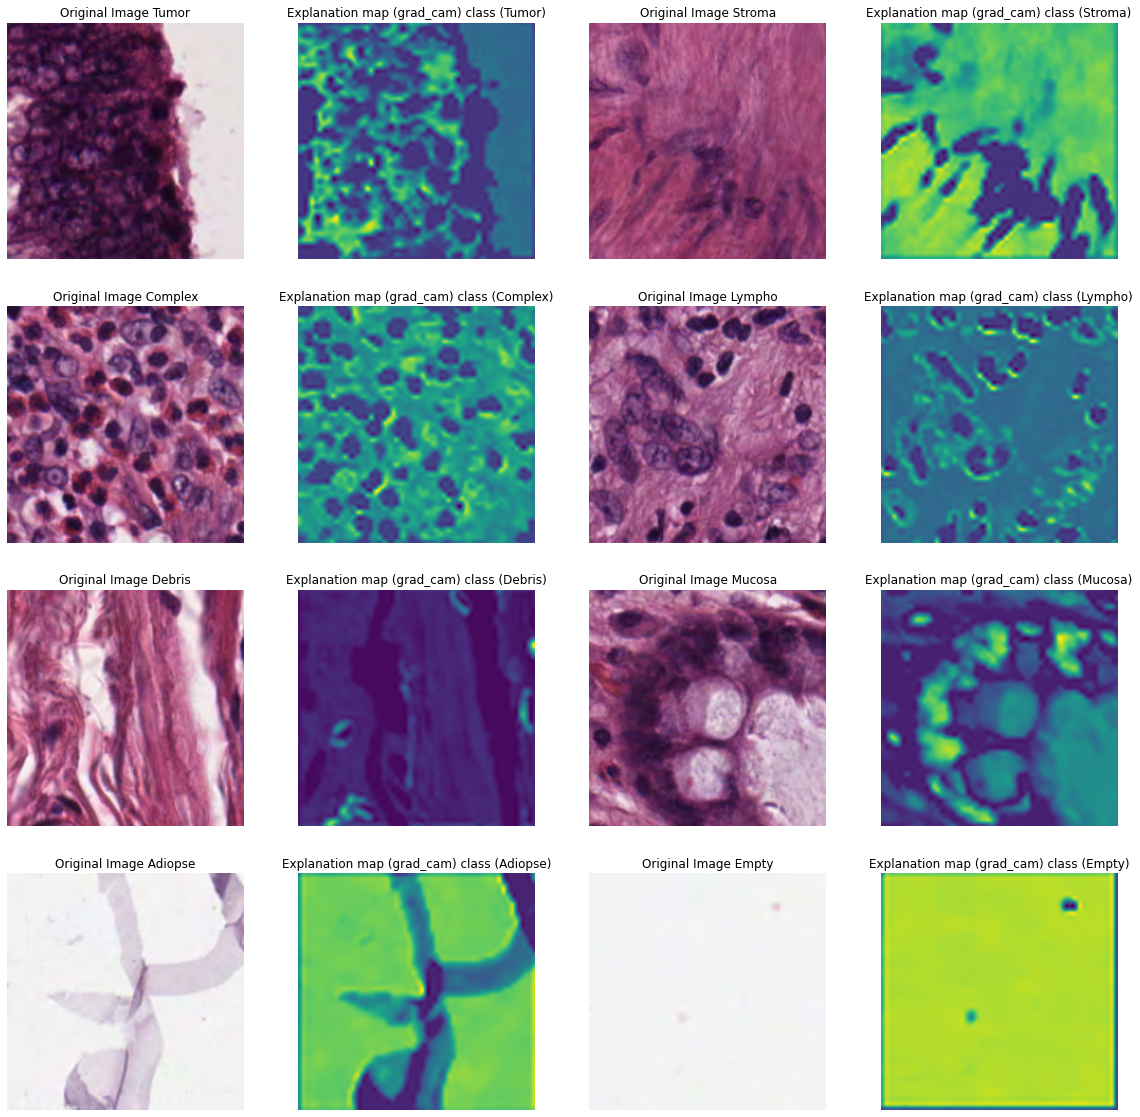

In [1150]:
get_unique_class_image(test_generator,'grad_cam')

## LIME (Local Interpretable Model-Agnostic Explanations)

In [1151]:
# Activate/Hide part of superpixels
def image_process(image,mask,superpixels):
    active_pixels = np.where(mask==1)[0]
    mask = np.zeros(superpixels.shape)
    for active in active_pixels:
        mask[superpixels == active] = 1 
    processed_image = copy.deepcopy(image)
    processed_image = processed_image * mask[:, :, np.newaxis]
    return processed_image

def LIME(image,label,model=model,n_new_image=150,num_top=5,kernel_width=0.25,seed=1000,kernel_size=4,max_dist=200, ratio=0.2):
    random.seed(seed)
    test_input = image.astype("double")
    #super-pixels
    superpixels = skimage.segmentation.quickshift(test_input,kernel_size=kernel_size,max_dist=max_dist, ratio=ratio)
    num_superpixels = np.unique(superpixels).shape[0]
    perturbations = np.random.binomial(1, 0.5, size=(n_new_image, num_superpixels))
    #predict classes of new generated images
    predictions = []
    for pert in perturbations:
        perturbed_img = image_process(test_input,pert,superpixels)
        pred = model.predict(np.expand_dims(image_batch[i], axis=0))
        predictions.append(pred)
    predictions = np.array(predictions)
    predictions.shape
    #Compute distances
    original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
    distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
    #Compute weights
    weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2))
    #Fit linear model
    #label = classes[np.argmax(label_batch[index])]
    #class_index = classes.index(label)
    simpler_model = LinearRegression()
    simpler_model.fit(X=perturbations, y=predictions[:, :, label], sample_weight=weights)
    c = simpler_model.coef_[0]
    top_features = np.argsort(c)[-num_top:] 
    mask = np.zeros(num_superpixels) 
    mask[top_features]= True #activate superpixels
    explanation_lime = image_process(test_input,mask,superpixels)
    return explanation_lime

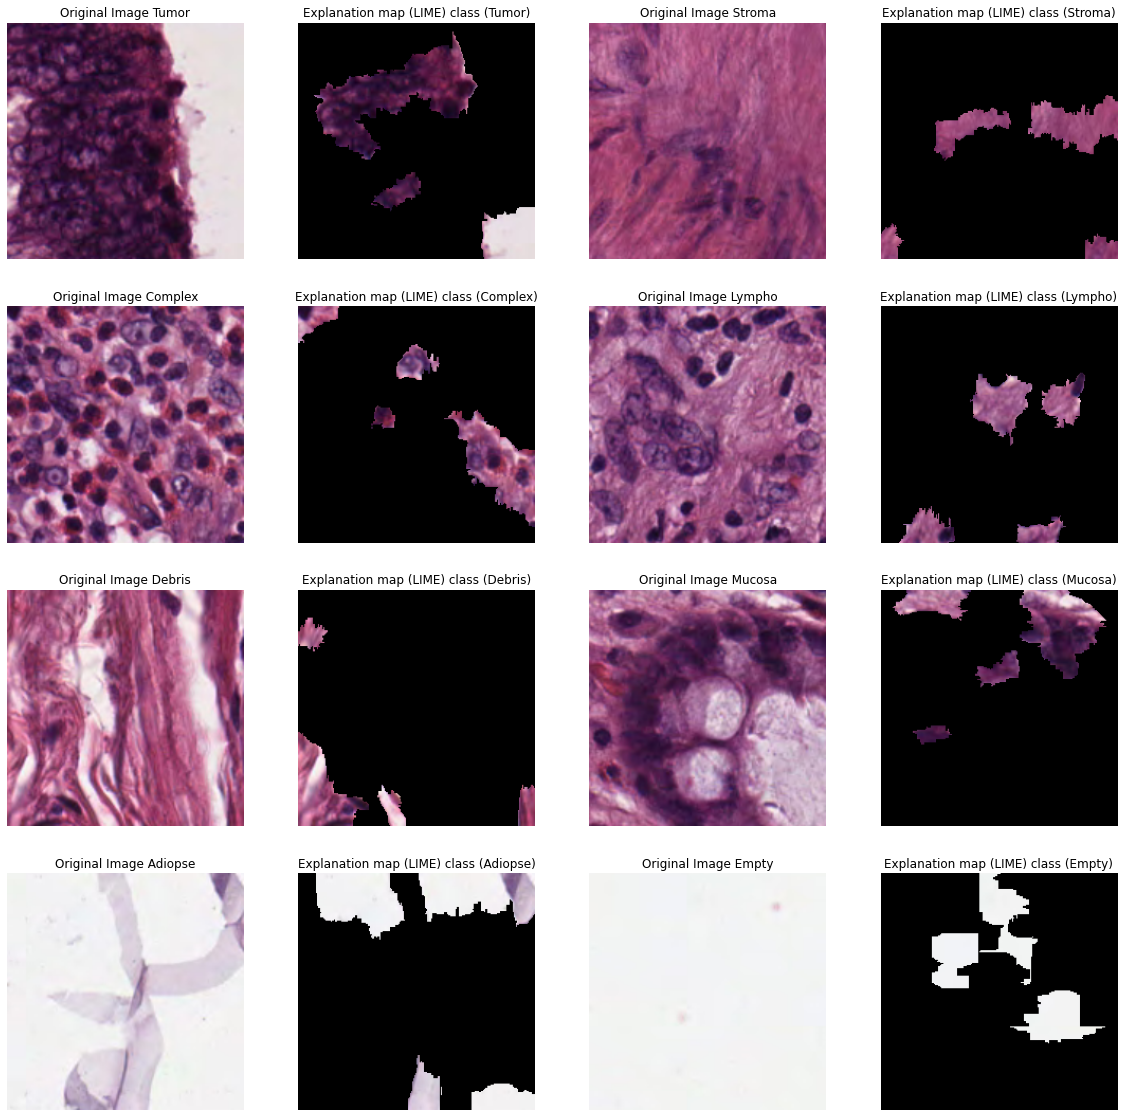

In [1152]:
get_unique_class_image(test_generator,'LIME')

## Quantitative evaluation of the explanation algorithms

In [1107]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [891]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    # Pre-processing image 
    img=images[0,:,:,:]
    img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,224,224,3))
    exmap1_thr[0,:,:,0]=img[0,:,:,0]*exmap1_msk
    exmap1_thr[0,:,:,1]=img[0,:,:,1]*exmap1_msk
    exmap1_thr[0,:,:,2]=img[0,:,:,2]*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

In [1112]:
#IG
test_generator.reset()
drop_rate = 0.
increase_rate = 0.
for _ in range(15):
    image_batch,label_batch=test_generator.next()
    for index in range(32):
        prediction=model(image_batch)
        explanation_map_IG, result = IG(image_batch[index], label=np.argmax(prediction[index]))
        drop_rate += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, result[:,:,1], class_index=np.argmax(prediction[index]), frac=0.9)[0]
        increase_rate += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, result[:,:,1], class_index=np.argmax(prediction[index]), frac=0.9)[1]
drop_rate /= (15*32)
increase_rate /= (15*32)
print('Integrated Gradients')
print('Drop Rate', round(drop_rate*100,2),'%')
print('Increase Rate', round(increase_rate*100,2),'%')

Integrated Gradients
Drop Rate 54.83 %
Increase Rate 23.96 %


In [1111]:
#LIME
test_generator.reset()
drop_rate = 0.
increase_rate = 0.
for _ in range(15):
    image_batch,label_batch=test_generator.next()
    for index in range(32):
        prediction=model(image_batch)
        explanation_lime = LIME(image_batch[index],np.argmax(prediction[index]))
        explanation_lime = rgb2gray(explanation_lime)
        drop_rate += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_lime, class_index=np.argmax(prediction[index]), frac=0.9)[0]
        increase_rate += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_lime, class_index=np.argmax(prediction[index]), frac=0.9)[1]
drop_rate /= (15*32)
increase_rate /= (15*32)
print('LIME')
print('Drop Rate', round(drop_rate*100,2),'%')
print('Increase Rate', round(increase_rate*100,2),'%')

Drop Rate 88.12 %
Increase Rate 11.88 %


In [1113]:
#GC
test_generator.reset()
drop_rate = 0.
increase_rate = 0.
for _ in range(15):
    image_batch,label_batch=test_generator.next()
    for index in range(32):
        prediction=model(image_batch)
        explanation_map_GC = grad_cam(model, np.expand_dims(image_batch[index], axis=0), 'max_pooling2d_1')
        drop_rate += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_GC, class_index=np.argmax(prediction[index]), frac=0.9)[0]
        increase_rate += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_GC, class_index=np.argmax(prediction[index]), frac=0.9)[1]
drop_rate /= (15*32)
increase_rate /= (15*32)
print('Grad-CAM')
print('Drop Rate', round(drop_rate*100,2),'%')
print('Increase Rate', round(increase_rate*100,2),'%')

Grad-CAM
Drop Rate 48.93 %
Increase Rate 29.58 %
